<a href="https://colab.research.google.com/github/emuemuJP/StudyPython/blob/master/notebooks/Optical%20Flow%20Annotations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optical Flow

Optical Flow is technique used to extract motion from multiple images, in practice we usually use only two frames of a video.

With Optical Flow, we compute a motion vector $(u, v)$ which encodes de displacement in $x$ and $y$ directions betwween two consecutive frames.

In [1]:
!pip install git+https://github.com/Guillem96/spynet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Guillem96/spynet-pytorch to /tmp/pip-req-build-erwwr58h
  Running command git clone -q https://github.com/Guillem96/spynet-pytorch /tmp/pip-req-build-erwwr58h
  Created wheel for spynet: filename=spynet-1.0-py3-none-any.whl size=11405 sha256=0b94c0dd4f2e35cd87661a0534072e7b12fc76cbccfd9c4aec4ab0eba8838705
  Stored in directory: /tmp/pip-ephem-wheel-cache-tts4bubz/wheels/c1/a2/d8/33bdcf465a793852b0c7a94a97cbe1eeb8cff6552c6d74ecd3
Successfully built spynet


In [2]:
!rm -rf taxi
!curl -O ftp://ftp.ira.uka.de/pub/vid-text/image_sequences/taxi/taxi.zip
!unzip -q taxi.zip
!rm taxi.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1454k  100 1454k    0     0   213k      0  0:00:06  0:00:06 --:--:--  354k


In [3]:
from pathlib import Path

import torch
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display

import torchvision.transforms as T

import spynet

## Formulation

Optical flow is based on the Brightness consistency assumtion. The intensity in location $(x, y)$ at time $t$ is almost equal at time $t + 1$.

$ f(x, y, t) = f(x + dx, y + dy, t + 1) $

$(dx, dy) = (u, v)$

With taylor series we can express the equation above as follows

$ f_x u + f_y v + f_t = 0 $

Above equation is called Optical Flow equation. In it, we can find $f_x$ and $f_y$, they are image gradients. Similarly $f_t$ is the gradient along time. But $(u,v$) is unknown. We cannot solve this one equation with two unknown variables. So several methods are provided to solve this problem:

- Discrete optimization methods
- Differential methods such as: [Lucas-kanade](http://cseweb.ucsd.edu/classes/sp02/cse252/lucaskanade81.pdf) and [Horn–Schunck](http://dspace.mit.edu/handle/1721.1/6337)
- *New* Deep Learning approaches like FlowNet and SpyNet


## Hamburg taxi sequence 

Famous image sequence. Old days, around 1970, generating fast sequences of images such as videos and move them to the computer was difficult. Two researchers installed a camera on their office window, and they were continously taking photos of the street.

In [4]:
taxis_fnames = sorted(list(Path('taxi').iterdir()))
print(f'Number of frames: {len(taxis_fnames)}')

Number of frames: 41


In [17]:
mkdir images

In [18]:
!ffmpeg -i "/content/IMG_4656.MOV" -vf fps=1 "images/%04d.jpg"

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

In [20]:
origin_fnames = sorted(list(Path('images').iterdir()))
print(f'Number of frames: {len(origin_fnames)}')

Number of frames: 33


In [6]:
STRIDE = 2 #@param {type: "slider", min: 1, max: 5}

In [22]:
rand_idx = np.random.randint(len(origin_fnames) - STRIDE, size=(1,)).item()

taxi1 = Image.open(origin_fnames[rand_idx])
taxi2 = Image.open(origin_fnames[rand_idx + STRIDE])

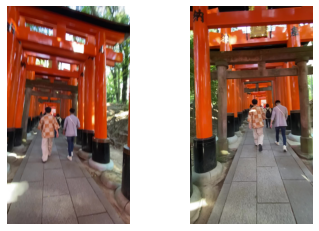

In [23]:
plt.subplot(121)
plt.imshow(taxi1, cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.imshow(taxi2, cmap='gray')
plt.axis('off');

OpenCV provides an algorithm to find the optical flow. It computes the optical flow for all the points in the frame. It is based on Gunner Farneback’s algorithm which is explained in [Two-Frame Motion Estimation Based on Polynomial Expansion](https://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf).

In [24]:
flow = cv.calcOpticalFlowFarneback(np.array(taxi1), 
                                   np.array(taxi2), 
                                   None, 0.5, 3, 15, 3, 5, 1.2, 0)

error: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

We can display the displacement of each pixel using a quiver plot.

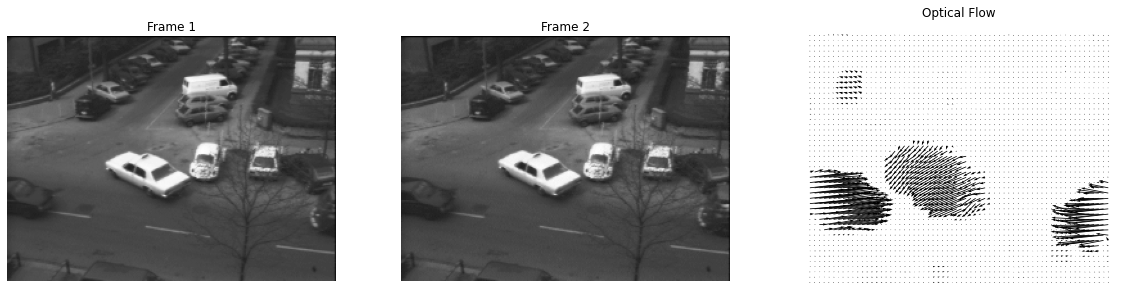

In [10]:
step = 4
plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.title('Frame 1')
plt.imshow(taxi1, cmap='gray')
plt.axis('off')

plt.subplot(132)
plt.title('Frame 2')
plt.imshow(taxi2, cmap='gray')
plt.axis('off')

plt.subplot(133)
plt.title('Optical Flow')
plt.quiver(np.arange(0, 256, step), np.arange(190, -1, -step), 
           flow[::step, ::step, 0], flow[::step, ::step, 1])
plt.axis('off');

Also, we can get a prettier representation of Optical Flow mapping the vector magnitudes to a color:

![](https://www.researchgate.net/profile/Christophoros_Nikou/publication/266149545/figure/fig1/AS:392088710598656@1470492641144/The-optical-flow-field-color-coding-Smaller-vectors-are-lighter-and-color-represents-the.png)

Where the vertical axis corresponds to the $v$ and the horizontal axis to $u$

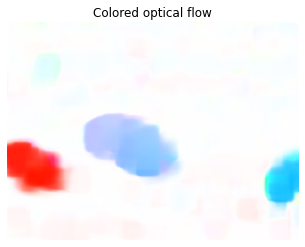

In [11]:
plt.title('Colored optical flow')
plt.imshow(spynet.flow.flow_to_image(flow))
plt.axis('off');

In [12]:
all_taxi_images = [np.array(Image.open(o)) for o in taxis_fnames]
optical_flows = [cv.calcOpticalFlowFarneback(im1, im2, 
                  None, 0.5, 3, 15, 3, 5, 1.2, 0) 
                 for im1, im2 in zip(all_taxi_images[:-1], all_taxi_images[1:])]
optical_flows = [spynet.flow.flow_to_image(o) for o in optical_flows]

In [13]:
def display_video(images):
    fig = plt.figure()
    plt.axis('off')
    im = plt.imshow(images[0], cmap='gray')
    plt.close()

    def init():
        im.set_data(images[0])

    def animate(i):
        im.set_data(images[i])
        return im

    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=len(images), interval=50)
    display(HTML(anim.to_html5_video()))

display_video(optical_flows)
display_video(all_taxi_images)

## Deep Learning Approach

To compute the optical flow with deep learning, we are going to use the *coarse to fine grained* approach defined in the SpyNet paper. Another famous NN to compute the Optical Flow is called FlowNet, but this net is much larger than the one we are using in the cells below: Spatial Pyramid Network (SPyNet) is much simpler and 96% smaller than FlowNet in terms of model parameters

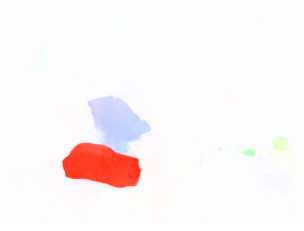

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'gpu')

@torch.no_grad()
def predict(frames1, frames2):
    images1 = torch.stack([tfms(o.convert('RGB')) for o in frames1]).to(device)
    images2 = torch.stack([tfms(o.convert('RGB')) for o in frames2]).to(device)
    return model((images1, images2))

tfms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[.485, .406, .456], 
                std= [.229, .225, .224])
])

model = spynet.SpyNet.from_pretrained('flying-chair')
model.to(device)
model.eval()

flow = predict([taxi1], [taxi2])[0]
plt.imshow(spynet.flow.flow_to_image(flow))
plt.axis('off');

In [ ]:
images = [Image.open(o) for o in taxis_fnames]
all_flows = []
for im1, im2 in zip(images[1:], images[:-1]):
    flow = predict([im1], [im2])[0]
    all_flows.append(spynet.flow.flow_to_image(flow))

display_video(all_flows)

## Optical Flow for action Recognition

Most of the top performing action recognition methods use optical flow as a “black box” input. In some video action recognition classifiers that are based on 2D convolutions, which actually they are not able to extract temporal features, the optical flow is a good external feature that let us improve the classification results in front of the raw RGB images.

While it may seem intuitive to include image motion in a task related to video, often video categories in datasets can be identified from a single image. For instance, playing the guitar can esily be predicted if a guitar appears within the image. Therefore, we can think that optical flow improves the models' results is because it encodes the temporal information that 2D convolutions cannot see. 

But surprisingly, in the paper "On the Integration of Optical Flow and Action Recognition" they experiment with optical flow and demonstate that, actually, it is good because of its capability of representing scenes independently of the appearance. Also, the paper describes that as the datasets get even larger, the gap between optical flow and images accuracy decreases because the model sees the same action a lot more environments with brightness, color and objects variations.

**Models that use Optical Flow as input**

- [LRCN](https://arxiv.org/abs/1411.4389)

## References

\[1\] High Accuracy Optical Flow Method Based on a Theory for Warping: Implementation and Qualitative/Quantitative Evaluation - Mohammad Faisal and John Barron

\[2\] On the Integration of Optical Flow and Action Recognition - Laura Sevilla-Lara, Yiyi Liao et.al

\[3\] FlowNet: Learning Optical Flow with Convolutional Networks

\[4\] Optical Flow Estimation using a Spatial Pyramid Network - Anurag Ranjan, Michael J. Black